In [1]:
from functools import reduce
from itertools import islice
import math
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from hyperspherical_vae.distributions import VonMisesFisher, HypersphericalUniform

%matplotlib inline

In [2]:
import pyspark
sc = pyspark.SparkContext('local[*]')
spark = pyspark.sql.SparkSession(sc)

In [3]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.15

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

# rv5 = generate_cluster(unit, (on, -off, off), [0,0,2], 1250000)
# rv6 = generate_cluster(unit, (-on, off, -off), [0,2,0], 1000000)
# 
# data = np.append(shuffle(rv1, rv2, rv3, rv4), shuffle(rv5, rv6), axis=1)

data = reduce(lambda a,b: np.append(a, b, axis=0), [rv1, rv2, rv3, rv4])

# ind_var = np.random.uniform(-1, 1, [data.shape[0], 20])

# data = np.append(data, ind_var, axis=1)

data = shuffle(data)

# data = reduce_correlation(data, [0.75, 0.75, 0.75])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.83249943, -2.69914232, -2.56578522, -2.43242811, -2.29907101,
        -2.16571391, -2.0323568 , -1.8989997 , -1.76564259, -1.63228549,
        -1.49892839, -1.36557128, -1.23221418, -1.09885707, -0.96549997,
        -0.83214287, -0.69878576, -0.56542866, -0.43207155, -0.29871445,
        -0.16535735, -0.03200024,  0.10135686,  0.23471397,  0.36807107,
         0.50142817,  0.63478528,  0.76814238,  0.90149949,  1.03485659,
         1.16821369,  1.3015708 ,  1.4349279 ,  1.56828501,  1.70164211,
         1.83499922,  1.96835632,  2.10171342,  2.23507053,  2.36842763,
         2.50178474,  2.63514184,  2.76849894,  2.90185605,  3.03521315,
         3.16857026,  3.30192736,  3.43528446,  3.56864157,  3.70199867,
         3.83535578])

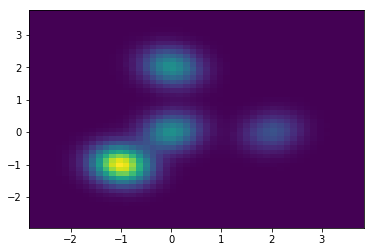

In [4]:
plt.hist2d(data[:,0], data[:,1], bins=50)

In [5]:
class VariationalAutoEncoder(object):
    def __init__(self, n_input_units, n_hidden_layers, n_hidden_units, n_latent_units,
                 learning_rate=0.005, batch_size=100, min_beta=1.0, max_beta=1.0,
                 distribution='normal'):
        self.n_input_units = n_input_units
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.distribution = distribution

    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units, distribution):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            self.distribution = distribution

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_mu(self, inputs):
            if self.distribution == 'normal':
                self.mu = tf.layers.Dense(units=self.n_latent_units)
            elif self.distribution == 'vmf':
                self.mu = tf.layers.Dense(units=self.n_latent_units + 1, 
                                          activation=lambda x: tf.nn.l2_normalize(x, axis=-1))
            else:
                raise NotImplemented
                
            self.applied_mu = self.mu.apply(inputs)
            return self.applied_mu

        def add_sigma(self, inputs):
            if self.distribution == 'normal':
                self.sigma = tf.layers.Dense(units=self.n_latent_units)
                self.applied_sigma = self.sigma.apply(inputs)
            elif self.distribution == 'vmf':
                self.sigma = tf.layers.Dense(units=1, activation=tf.nn.softplus)
                self.applied_sigma = self.sigma.apply(inputs) + 1
            else:
                raise NotImplemented
            return self.applied_sigma

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            mu = self.add_mu(layer)
            sigma = self.add_sigma(layer)

            return mu, sigma

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            mu = sess.run([self.mu.kernel, self.mu.bias])

            sigma = sess.run([self.sigma.kernel, self.sigma.bias])

            return layers, mu, sigma

    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_output(self, inputs):
            self.output = tf.layers.Dense(units=self.n_output_units)
            self.applied_output = self.output.apply(inputs)
            return self.applied_output

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            output = self.add_output(layer)

            return output

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            output = sess.run([self.output.kernel, self.output.bias])

            return layers, output

    def sampled_z(self, mu, sigma, batch_size):
        if self.distribution == 'normal':
            epsilon = tf.random_normal(tf.stack([int(batch_size), self.n_latent_units]))
            z = mu + tf.multiply(epsilon, tf.exp(0.5 * sigma))
            loss = tf.reduce_mean(-0.5 * self.beta * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), 1))
        elif self.distribution == 'vmf':
            self.q_z = VonMisesFisher(mu, sigma, validate_args=True, allow_nan_stats=False)
            z = self.q_z.sample()
            self.p_z = HypersphericalUniform(self.n_latent_units, validate_args=True, allow_nan_stats=False)
            loss = tf.reduce_mean(-self.q_z.kl_divergence(self.p_z))
        else:
            raise NotImplemented

        return z, loss

    def build_feature_loss(self, x, output):
        return tf.reduce_mean(tf.reduce_sum(tf.squared_difference(x, output), 1))

    def initialize_tensors(self):
        self.x = tf.placeholder("float32", [self.batch_size, self.n_input_units])
        self.beta = tf.placeholder("float32", [1, 1])
        self.encoder = self.Encoder(self.n_hidden_layers, self.n_hidden_units, self.n_latent_units, 
                                    self.distribution)
        mu, sigma = self.encoder.build(self.x)
        self.mu = mu
        self.sigma = sigma
        
        z, latent_loss = self.sampled_z(self.mu, self.sigma, self.batch_size)
        self.z = z
        self.latent_loss = latent_loss
        
        self.decoder = self.Decoder(self.n_hidden_layers, self.n_hidden_units, self.n_input_units)
        self.output = self.decoder.build(self.z)
        
        self.feature_loss = self.build_feature_loss(self.x, self.output)
        self.loss = self.feature_loss + self.latent_loss
        

    def generate_beta_values(self, data_count, epochs):
        num_batches = int(data_count / self.batch_size)
        total_steps = (num_batches * epochs) - epochs
        beta_delta = self.max_beta - self.min_beta
        log_beta_step = 5 / float(total_steps)
        beta_values = [
            self.min_beta + (beta_delta * (1 - math.exp(-5 + (i * log_beta_step))))
            for i in range(total_steps)
        ]
        return beta_values

    def train_from_rdd(self, data_rdd, epochs=1):
        self.initialize_tensors()

        data_count = data_rdd.count()
        beta_values = self.generate_beta_values(data_count, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_index in range(epochs):
                iterator = data_rdd.toLocalIterator()
                batch_index = 0
                while True:
                    batch = np.array(list(islice(iterator, self.batch_size)))
                    if batch.shape[0] == self.batch_size:
                        beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                        feed_dict = {self.x: np.array(batch), self.beta: np.array([[beta]])}

                        if not batch_index % 1000:
                            print("beta: {}".format(beta))
                            ls, f_ls, d_ls = sess.run([self.loss, self.feature_loss, self.latent_loss],
                                                      feed_dict=feed_dict)
                            print("loss={}, avg_feature_loss={}, avg_latent_loss={}".format(ls, np.mean(f_ls),
                                                                                            np.mean(d_ls)))
                            print('running batch {} in epoch {}'.format(batch_index, epoch_index))
                        sess.run(optimizer, feed_dict=feed_dict)
                        batch_index += 1
                    else:
                        print("incomplete batch: {}".format(batch.shape))
                        break

            print("evaluating model...")
            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)

    def train(self, data, visualize=False, epochs=1):
        self.initialize_tensors()
        
        data_size = data.shape[0]
        batch_size = self.batch_size
        beta_values = self.generate_beta_values(data_size, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            i = 0
            while (i * batch_size) < data_size:
                batch = data[i * batch_size:(i + 1) * batch_size]
                beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                feed_dict = {self.x: batch, self.beta: np.array([[beta]])}
                sess.run(optimizer, feed_dict=feed_dict)
                if visualize and (not i % int((data_size / batch_size) / 3) or i == int(data_size / batch_size) - 1):
                    ls, d, f_ls, d_ls = sess.run([self.loss, self.output, self.feature_loss, self.latent_loss],
                                                 feed_dict=feed_dict)
                    plt.scatter(batch[:, 0], batch[:, 1])
                    plt.show()
                    plt.scatter(d[:, 0], d[:, 1])
                    plt.show()
                    print(i, ls, np.mean(f_ls), np.mean(d_ls))

                i += 1

            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)


class VariationalAutoEncoderModel(object):
    def __init__(self, encoder_layers, mu, sigma, decoder_layers, output):
        self.encoder = self.EncoderModel(encoder_layers, mu, sigma)
        self.decoder = self.DecoderModel(decoder_layers, output)

    def save(self, path):
        encoder_layers, encoder_mu, encoder_sigma = self.encoder.dump()
        decoder_layers, decoder_output = self.decoder.dump()
        serializable_model = (encoder_layers, encoder_mu, encoder_sigma, decoder_layers, decoder_output)
        pickle.dump(serializable_model, open(path, 'w+'))

    def encode(self, x):
        return self.encoder.encode(x)

    def project(self, x):
        return self.encoder.encode(x)[0]

    def decode(self, x):
        return self.decoder.decode(x)

    @classmethod
    def load(cls, path):
        return cls(*pickle.load(open(path, 'r')))

    class Layer(object):
        def __init__(self, kernel, bias, activation='linear'):
            self.kernel = kernel
            self.bias = bias
            self.activation = activation

        def dump(self):
            return (self.kernel, self.bias, self.activation)

        @property
        def apply_func(self):
            kernel, bias = self.kernel, self.bias

            linear = lambda inputs: np.matmul(inputs, kernel) + bias

            if self.activation == 'linear':
                f = linear
            elif self.activation == 'sigmoid':
                f = lambda inputs: 1 / (1 + np.exp(-linear(inputs)))

            return f

        def apply(self, inputs):
            return self.apply_func(inputs)

    class EncoderModel(object):
        def __init__(self, encoder_layers, mu, sigma):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in encoder_layers
            ]
            self.mu = VariationalAutoEncoderModel.Layer(*mu)
            self.sigma = VariationalAutoEncoderModel.Layer(*sigma)

        def dump(self):
            encoder_layers = [l.dump()[:2] for l in self.layers]
            encoder_mu = self.mu.dump()[:2]
            encoder_sigma = self.sigma.dump()[:2]
            return encoder_layers, encoder_mu, encoder_sigma

        def encode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.mu.apply(x), self.sigma.apply(x)

    class DecoderModel(object):
        def __init__(self, decoder_layers, output):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in decoder_layers
            ]
            self.output = VariationalAutoEncoderModel.Layer(*output)

        def dump(self):
            decoder_layers = [l.dump()[:2] for l in self.layers]
            decoder_output = self.output.dump()[:2]
            return decoder_layers, decoder_output

        def decode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.output.apply(x)


In [9]:
rdd = sc.parallelize(data)

model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=2, 
                               n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.005, batch_size=100, 
                               min_beta=0.01, max_beta=1, distribution='normal')\
    .train_from_rdd(rdd, epochs=1)

beta: 0.9933294324709053
loss=4.90695333480835, avg_feature_loss=4.291430473327637, avg_latent_loss=0.6155229210853577
running batch 0 in epoch 0


beta: 0.991669387004781
loss=3.109652519226074, avg_feature_loss=2.3707802295684814, avg_latent_loss=0.7388723492622375
running batch 1000 in epoch 0


beta: 0.989596220625394
loss=2.867354154586792, avg_feature_loss=2.0870132446289062, avg_latent_loss=0.7803409099578857
running batch 2000 in epoch 0


beta: 0.9870071235649049
loss=2.3265438079833984, avg_feature_loss=1.2379647493362427, avg_latent_loss=1.0885789394378662
running batch 3000 in epoch 0


beta: 0.9837737006928752
loss=2.040351390838623, avg_feature_loss=0.9182459115982056, avg_latent_loss=1.122105598449707
running batch 4000 in epoch 0


beta: 0.9797356043121276
loss=2.2725419998168945, avg_feature_loss=0.8787100315093994, avg_latent_loss=1.3938319683074951
running batch 5000 in epoch 0


beta: 0.9746925824045195
loss=2.079235553741455, avg_feature_loss=0.7968091368675232, avg_latent_loss=1.2824264764785767
running batch 6000 in epoch 0


beta: 0.9683945479935862
loss=2.049178123474121, avg_feature_loss=0.684943675994873, avg_latent_loss=1.364234447479248
running batch 7000 in epoch 0


beta: 0.9605291771568142
loss=2.1052303314208984, avg_feature_loss=0.8664880394935608, avg_latent_loss=1.2387423515319824
running batch 8000 in epoch 0


beta: 0.9507064206643211
loss=1.9485137462615967, avg_feature_loss=0.6675841808319092, avg_latent_loss=1.2809295654296875
running batch 9000 in epoch 0


beta: 0.9384391611652869
loss=2.0060198307037354, avg_feature_loss=0.6829290986061096, avg_latent_loss=1.3230907917022705
running batch 10000 in epoch 0


beta: 0.9231190566985162
loss=1.7532199621200562, avg_feature_loss=0.5314334630966187, avg_latent_loss=1.2217864990234375
running batch 11000 in epoch 0


beta: 0.9039863725899553
loss=2.0592494010925293, avg_feature_loss=0.7125407457351685, avg_latent_loss=1.3467086553573608
running batch 12000 in epoch 0


beta: 0.8800923056799046
loss=1.930182695388794, avg_feature_loss=0.6761106252670288, avg_latent_loss=1.2540720701217651
running batch 13000 in epoch 0


beta: 0.8502519325120586
loss=1.7397935390472412, avg_feature_loss=0.5496420860290527, avg_latent_loss=1.1901514530181885
running batch 14000 in epoch 0


beta: 0.8129854481522215
loss=1.724955677986145, avg_feature_loss=0.49337342381477356, avg_latent_loss=1.2315822839736938
running batch 15000 in epoch 0


beta: 0.766444781628706
loss=1.643485426902771, avg_feature_loss=0.594866156578064, avg_latent_loss=1.048619270324707
running batch 16000 in epoch 0


beta: 0.7083219488028798
loss=1.6524548530578613, avg_feature_loss=0.57793790102005, avg_latent_loss=1.074517011642456
running batch 17000 in epoch 0


beta: 0.6357345978247412
loss=1.6136823892593384, avg_feature_loss=0.6635584235191345, avg_latent_loss=0.9501239657402039
running batch 18000 in epoch 0


beta: 0.5450830712927733
loss=1.3491926193237305, avg_feature_loss=0.48216789960861206, avg_latent_loss=0.8670246601104736
running batch 19000 in epoch 0


beta: 0.431871896730817
loss=1.1902421712875366, avg_feature_loss=0.532715380191803, avg_latent_loss=0.6575267910957336
running batch 20000 in epoch 0


beta: 0.29048685297010346
loss=0.9488694667816162, avg_feature_loss=0.47039616107940674, avg_latent_loss=0.4784733057022095
running batch 21000 in epoch 0


beta: 0.11391655700272756
loss=0.6356500387191772, avg_feature_loss=0.4235582649707794, avg_latent_loss=0.21209180355072021
running batch 22000 in epoch 0


incomplete batch: (0,)
evaluating model...


In [6]:
model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=2, 
                               n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.005, batch_size=100, 
                               min_beta=1, max_beta=1, distribution='vmf')\
    .train(data, epochs=1, visualize=True)

(array([2.97880e+04, 5.68307e+05, 2.29960e+05, 8.67370e+04, 3.90430e+04,
        1.93480e+04, 1.04240e+04, 5.79400e+03, 3.49300e+03, 2.14500e+03,
        1.35400e+03, 8.87000e+02, 6.33000e+02, 4.47000e+02, 3.61000e+02,
        2.42000e+02, 1.91000e+02, 1.51000e+02, 1.43000e+02, 8.60000e+01,
        7.00000e+01, 5.40000e+01, 5.90000e+01, 3.70000e+01, 3.90000e+01,
        3.60000e+01, 2.90000e+01, 2.10000e+01, 2.40000e+01, 2.50000e+01,
        1.80000e+01, 2.00000e+01, 1.60000e+01, 1.10000e+01, 1.90000e+01,
        1.40000e+01, 1.60000e+01, 3.10000e+01, 3.70000e+01, 5.40000e+01,
        9.50000e+01, 1.97000e+02, 3.94000e+02, 1.48700e+03, 6.91400e+03,
        2.93660e+04, 8.61380e+04, 1.73057e+05, 1.75687e+05, 1.65230e+04,
        4.50500e+03, 2.08900e+03, 1.14500e+03, 7.00000e+02, 4.70000e+02,
        3.34000e+02, 3.05000e+02, 2.88000e+02, 3.15000e+02, 4.33000e+02,
        6.38000e+02, 1.13600e+03, 2.20400e+03, 5.52300e+03, 2.07570e+04,
        1.93920e+05, 2.05630e+04, 3.01400e+03, 9.92

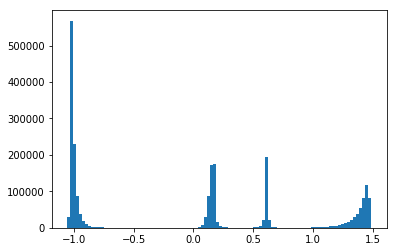

In [14]:
plt.hist(model.encoder.encode(data)[0], bins=100)

In [23]:
from sklearn.mixture import GaussianMixture



In [33]:
mus = model.encoder.encode(data)[0]

results = []

for i in range(1,10):
    m = GaussianMixture(i).fit(mus)
    results.append((i, m.score(mus), m.aic(mus), m.bic(mus)))

In [31]:
results

[(1, -1.349808787495403, 6074143.5437293136, 6074168.796610862),
 (2, -0.16352232973647432, 735860.4838141345, 735923.61601800541),
 (3, 0.2106959228959403, -948115.65303173137, -948014.6415055379),
 (4, 0.63413533432107461, -2853587.0044448357, -2853448.1135963197),
 (5, 0.65035754820199487, -2926580.9669089769, -2926404.1967381383),
 (6, 0.86345505427588054, -3885513.7442414626, -3885299.0947483014),
 (7, 0.79605181388766111, -3582193.162494475, -3581940.6336789913),
 (8, 0.8646548225404691, -3890900.7014321107, -3890610.2932943045),
 (9, 0.88927691745299919, -4001694.1285384963, -4001365.8410783675)]

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.5826096 , -1.52876103, -1.47491246, -1.42106389, -1.36721532,
        -1.31336675, -1.25951818, -1.20566961, -1.15182104, -1.09797247,
        -1.0441239 , -0.99027533, -0.93642676, -0.88257819, -0.82872962,
        -0.77488105, -0.72103248, -0.66718391, -0.61333534, -0.55948677,
        -0.5056382 , -0.45178963, -0.39794106, -0.34409249, -0.29024392,
        -0.23639535, -0.18254678, -0.12869821, -0.07484964, -0.02100107,
         0.0328475 ,  0.08669607,  0.14054464,  0.19439321,  0.24824178,
         0.30209035,  0.35593892,  0.40978749,  0.46363606,  0.51748463,
         0.5713332 ,  0.62518177,  0.67903034,  0.73287891,  0.78672748,
         0.84057605,  0.89442462,  0.94827319,  1.0021217

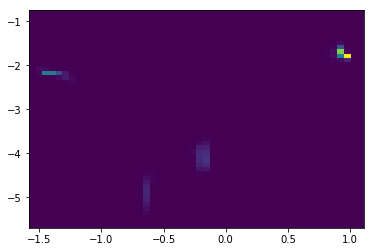

In [22]:
plt.hist2d(model.encoder.encode(data)[0].squeeze(1), model.encoder.encode(data)[1].squeeze(1), bins=50)